# Modern Portfolio Theory

## 1.ดาวน์โหลดและนำเข้า  library

In [ ]:
!pip install yfinance scipy pandas numpy matplotlib

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import datetime
from scipy.optimize import minimize
import matplotlib.pyplot as plt


## 2.โหลดข้อมูล ESG Score (esg-score.csv)

In [ ]:
esg_df = pd.read_csv('/content/drive/MyDrive/dataset/esg-score.csv')
esg_df.head()

,ชื่อย่อ,Company Name,ชื่อบริษัท,กลุ่มอุตสาหกรรม,2024,2023,2022,2021,2020,2019,2018,2017,2016,2015
0,AAV,ASIA AVIATION PUBLIC COMPANY LIMITED,บริษัท เอเชีย เอวิเอชั่น จำกัด (มหาชน),Services,NaN,NaN,Yes,Yes,Yes,Yes,NaN,NaN,NaN,NaN
1,ACE,ABSOLUTE CLEAN ENERGY PUBLIC COMPANY LIMITED,บริษัท แอ๊บโซลูท คลีน เอ็นเนอร์จี้ จำกัด (มหาชน),Resources,AAA,AA,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ADB,APPLIED DB PUBLIC COMPANY LIMITED,บริษัท แอ็พพลาย ดีบี จำกัด (มหาชน),Industrials,AA,A,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN
3,ADVANC,ADVANCED INFO SERVICE PUBLIC COMPANY LIMITED,บริษัท แอดวานซ์ อินโฟร์ เซอร์วิส จำกัด (มหาชน),Technology,AA,AAA,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes
4,AGE,ASIA GREEN ENERGY PUBLIC COMPANY LIMITED,บริษัท เอเชีย กรีน เอนเนอจี จำกัด (มหาชน),Resources,NaN,BBB,Yes,Yes,Yes,Yes,Yes,NaN,NaN,NaN


## 3.สร้างรายการหุ้นแยกตามเงื่อนไข

### 3.1 ดึงรายชื่อหุ้นที่ได้ ESG Rating = “AAA” ในปี 2024

In [ ]:
# กรองหาเฉพาะแถวที่คอลัมน์ "2024" == "AAA"
aaa_2024 = esg_df[esg_df['2024'] == 'AAA']['ชื่อย่อ'].tolist()
print(f"จำนวนหุ้นที่ได้ AAA ในปี 2024: {len(aaa_2024)} ตัว")
print(aaa_2024[:10])  # แสดงตัวอย่างสัก 10 ตัวแรก


จำนวนหุ้นที่ได้ AAA ในปี 2024: 56 ตัว
['ACE', 'AJ', 'AMATA', 'BANPU', 'BAY', 'BBL', 'BCPG', 'BEM', 'BGC', 'BGRIM']


### 3.2 ดึงรายชื่อหุ้นที่มี ESG Rating ไม่เป็น NaN ในปี 2024 (คือมีค่าใดๆ ถือว่ามี Rating)

In [ ]:
# กรองหาเฉพาะแถวที่คอลัมน์ "2024" ไม่ใช่ค่าว่าง (NaN หรือ empty string)
esg_2024_all = esg_df[esg_df['2024'].notnull() & (esg_df['2024'] != '')]['ชื่อย่อ'].tolist()
print(f"จำนวนหุ้นทั้งหมดที่มี ESG Rating ในปี 2024: {len(esg_2024_all)} ตัว")
print(esg_2024_all[:10])


จำนวนหุ้นทั้งหมดที่มี ESG Rating ในปี 2024: 224 ตัว
['ACE', 'ADB', 'ADVANC', 'AH', 'AJ', 'AKP', 'AKR', 'ALLA', 'AMATA', 'AMATAV']


## 4. แปลงชื่อย่อให้เป็นรูปแบบที่ yfinance ดึงได้ (เติม “.BK”)

In [ ]:
# เพิ่ม .BK ต่อท้าย
def add_bk_suffix(tickers):
    return [tk + '.BK' for tk in tickers]

tickers_aaa_2024 = add_bk_suffix(aaa_2024)
tickers_esg_2024 = add_bk_suffix(esg_2024_all)

# ตรวจสอบตัวอย่าง
print(tickers_aaa_2024[:5])
print(tickers_esg_2024[:5])


['ACE.BK', 'AJ.BK', 'AMATA.BK', 'BANPU.BK', 'BAY.BK']
['ACE.BK', 'ADB.BK', 'ADVANC.BK', 'AH.BK', 'AJ.BK']


## 5. ดึงข้อมูลราคา (Historical Price Data)

In [ ]:
# กำหนดช่วงเวลา In-Sample (2023) และ Out-of-Sample (2024)
start_train = '2021-01-01'
end_train = '2023-12-31'

start_test = '2024-01-01'
end_test = '2024-12-31'

# ฟังก์ชันดึงราคา Adjusted Close แล้วส่งกลับ DataFrame
def download_price_data(tickers, start_date, end_date):
    """

    คืนค่า DataFrame ที่คอลัมน์เป็น ticker แต่ละตัว และ index เป็นวันที่
    ค่าใน DataFrame คือราคาปิดแบบ Adjusted Close
    """
    data = yf.download(tickers, start=start_date, end=end_date, progress=False,auto_adjust=False)['Adj Close']

    # ถ้าได้เป็น Series (กรณี tickers มีตัวเดียว) ให้แปลงเป็น DataFrame
    if isinstance(data, pd.Series):
        data = data.to_frame()

    return data

In [ ]:
# ดึงข้อมูล In-Sample
price_train_aaa = download_price_data(tickers_aaa_2024, start_train, end_train)
price_train_esg = download_price_data(tickers_esg_2024, start_train, end_train)

ERROR:yfinance:
2 Failed downloads:
ERROR:yfinance:['GULF.BK', 'BKIH.BK']: YFPricesMissingError('possibly delisted; no price data found  (1d 2021-01-01 -> 2023-12-31) (Yahoo error = "Data doesn\'t exist for startDate = 1609434000, endDate = 1703955600")')
ERROR:yfinance:
4 Failed downloads:
ERROR:yfinance:['GULF.BK', 'BKIH.BK', 'STECON.BK', 'CPAXT.BK']: YFPricesMissingError('possibly delisted; no price data found  (1d 2021-01-01 -> 2023-12-31) (Yahoo error = "Data doesn\'t exist for startDate = 1609434000, endDate = 1703955600")')


In [ ]:
# ดึงข้อมูล Out-of-Sample (Backtest)
price_test_aaa = download_price_data(tickers_aaa_2024, start_test, end_test)
price_test_esg = download_price_data(tickers_esg_2024, start_test, end_test)


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['GULF.BK']: YFPricesMissingError('possibly delisted; no price data found  (1d 2024-01-01 -> 2024-12-31) (Yahoo error = "Data doesn\'t exist for startDate = 1704042000, endDate = 1735578000")')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['GULF.BK']: YFPricesMissingError('possibly delisted; no price data found  (1d 2024-01-01 -> 2024-12-31) (Yahoo error = "Data doesn\'t exist for startDate = 1704042000, endDate = 1735578000")')


In [ ]:
price_test_aaa["GULF.BK"]

,GULF.BK
Date,
2024-01-03,NaN
2024-01-04,NaN
2024-01-05,NaN
2024-01-08,NaN
2024-01-09,NaN
...,...
2024-12-24,NaN
2024-12-25,NaN
2024-12-26,NaN


In [ ]:
price_test_aaa.head()

Ticker,ACE.BK,BEM.BK,PTTGC.BK,GPSC.BK,BANPU.BK,BCPG.BK,TPIPP.BK,MTC.BK,M-CHAI.BK,CPF.BK,...,CPN.BK,TTB.BK,BAY.BK,PR9.BK,RATCH.BK,IVL.BK,STGT.BK,TMT.BK,TVO.BK,TFMAMA.BK
Date,,,,,,,,,,,,,,,,,,,,,
2024-01-03,1.56,7.715559,36.805031,47.826702,6.184898,8.174157,3.110073,45.532146,61.865398,18.555496,...,63.394466,1.555883,26.836285,15.403889,29.418612,26.683678,6.132204,5.970567,19.636744,204.266983
2024-01-04,1.57,7.811405,35.617771,48.792904,6.093944,8.174157,3.110073,45.037235,61.376343,18.555496,...,63.394466,1.555883,26.836285,15.403889,29.648443,26.683678,6.176321,5.970567,19.547079,207.157562
2024-01-05,1.56,7.715559,35.380322,47.102058,6.093944,8.127447,3.128260,43.552494,61.376343,18.555496,...,61.996056,1.565256,27.073776,15.791408,29.418612,25.968937,6.352787,6.018717,19.636744,207.157562
2024-01-08,1.57,7.667636,34.430515,46.377411,6.048467,7.940610,3.128260,44.294861,60.642761,18.170927,...,61.063786,1.527764,26.836285,15.500769,28.958946,25.492441,6.396904,5.922418,19.547079,205.230499
2024-01-09,1.56,7.619714,34.667965,45.411213,5.912035,7.847190,3.091885,44.294861,61.131813,18.074785,...,61.996056,1.555883,26.836285,15.888288,28.729115,25.015951,6.441020,5.922418,19.367746,204.266983


In [ ]:
# ตรวจสอบขนาดของ DataFrame
print("In-Sample (AAA) shape:", price_train_aaa.shape)
print("In-Sample (ESG_ALL) shape:", price_train_esg.shape)

print("Out-of-Sample (AAA) shape:", price_test_aaa.shape)
print("Out-of-Sample (ESG_ALL) shape:", price_test_esg.shape)

In-Sample (AAA) shape: (725, 56)
In-Sample (ESG_ALL) shape: (725, 224)
Out-of-Sample (AAA) shape: (243, 56)
Out-of-Sample (ESG_ALL) shape: (243, 224)


In [ ]:
# ตรวจสอบและลบคอลัมน์ที่มี NaN
price_train_aaa.dropna(axis=1, inplace=True)
price_train_esg.dropna(axis=1, inplace=True)
price_test_aaa.dropna(axis=1, inplace=True)
price_test_esg.dropna(axis=1, inplace=True)

print("Shape after dropping columns with NaN:")
print("price_train_aaa:", price_train_aaa.shape)
print("price_train_esg:", price_train_esg.shape)
print("price_test_aaa:", price_test_aaa.shape)
print("price_test_esg:", price_test_esg.shape)

Shape after dropping columns with NaN:
price_train_aaa: (725, 50)
price_train_esg: (725, 197)
price_test_aaa: (243, 54)
price_test_esg: (243, 218)


In [ ]:
# หาเฉพาะหุ้นที่ไม่มี NaN ทั้งใน train และ test
valid_columns_aaa = list(set(price_train_aaa.columns) & set(price_test_aaa.columns))
valid_columns_aaa = [col for col in valid_columns_aaa
                     if not price_train_aaa[col].isna().any() and not price_test_aaa[col].isna().any()]

valid_columns_esg = list(set(price_train_esg.columns) & set(price_test_esg.columns))
valid_columns_esg = [col for col in valid_columns_esg
                     if not price_train_esg[col].isna().any() and not price_test_esg[col].isna().any()]

# เลือกเฉพาะหุ้นที่มีข้อมูลครบทั้ง 2 ช่วงเวลา
price_train_aaa = price_train_aaa[valid_columns_aaa]
price_test_aaa = price_test_aaa[valid_columns_aaa]

price_train_esg = price_train_esg[valid_columns_esg]
price_test_esg = price_test_esg[valid_columns_esg]

# ตรวจสอบอีกครั้ง
print("Matched shape after column filtering:")
print("price_train_aaa:", price_train_aaa.shape)
print("price_test_aaa:", price_test_aaa.shape)
print("price_train_esg:", price_train_esg.shape)
print("price_test_esg:", price_test_esg.shape)


Matched shape after column filtering:
price_train_aaa: (725, 50)
price_test_aaa: (243, 50)
price_train_esg: (725, 197)
price_test_esg: (243, 197)


## 6. คำนวณ Returns และ Covariance (In-Sample)

### 6.1 คำนวณ Daily Returns

In [ ]:
# คำนวณ Simple Return = (P_t / P_t-1) - 1
return_train_aaa = price_train_aaa.pct_change().dropna()
return_train_esg = price_train_esg.pct_change().dropna()

# เช็คตัวอย่าง
return_train_aaa.head()


Ticker,ACE.BK,BEM.BK,PTTGC.BK,GPSC.BK,BANPU.BK,BCPG.BK,TPIPP.BK,MTC.BK,M-CHAI.BK,CPF.BK,...,CPN.BK,TTB.BK,BAY.BK,PR9.BK,RATCH.BK,IVL.BK,STGT.BK,TMT.BK,TVO.BK,TFMAMA.BK
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-05,0.044199,0.005988,0.000000,0.072785,-0.008928,0.127660,0.042056,0.016949,-0.031088,0.026316,...,0.041667,0.056604,0.032000,0.044944,0.013954,-0.012579,0.009967,-0.006944,-0.021583,-0.002584
2021-01-06,0.015873,-0.011905,0.008368,-0.058997,0.018018,-0.025157,-0.017937,-0.008333,0.042781,-0.025641,...,-0.030000,0.026786,0.062016,-0.005376,-0.009174,-0.044586,-0.046052,0.027972,0.044118,0.000000
2021-01-07,0.000000,0.024096,0.033195,0.047022,-0.035398,0.000000,0.004566,0.067227,-0.025641,-0.008772,...,0.005155,0.069565,0.014598,-0.010811,0.000000,-0.006666,0.006897,0.000000,0.000000,0.000000
2021-01-08,0.015625,0.005882,-0.004016,-0.017964,-0.119266,-0.012903,0.004545,-0.003937,0.050000,-0.008850,...,0.015385,-0.016260,-0.028777,-0.010929,-0.013889,0.013423,-0.006849,-0.006803,-0.021127,0.005181
2021-01-11,0.020513,-0.023392,0.004032,0.000000,0.010417,0.013072,0.009050,0.023715,-0.062657,0.000000,...,-0.025253,-0.024793,-0.007407,0.033149,0.000000,-0.006623,0.041379,-0.006849,0.000000,-0.002577


### 6.2 หาค่าเฉลี่ย (Expected Return) และ Covariance Matrix

In [ ]:
# สมมติเราคำนวณ Expected Return เฉลี่ยรายวัน (Daily Mean Return)
mu_aaa = return_train_aaa.mean()        # Series ของแต่ละ ticker
cov_aaa = return_train_aaa.cov()        # DataFrame covariance matrix

mu_esg = return_train_esg.mean()
cov_esg = return_train_esg.cov()

# แปลงเป็นค่า Annualized (ถ้าต้องการ) เช่น คูณด้วย 252 วันทำการในปี
trading_days = 252
mu_aaa_annual = mu_aaa * trading_days
cov_aaa_annual = cov_aaa * trading_days

mu_esg_annual = mu_esg * trading_days
cov_esg_annual = cov_esg * trading_days


## 7. สร้างฟังก์ชันสำหรับ Modern Portfolio Theory (MPT)

In [ ]:
def portfolio_performance(weights, mu, cov, risk_free_rate=0):
    """
    คำนวณ Portfolio Expected Return, Volatility, และ Sharpe Ratio
    - weights: numpy array shape = (n_assets,)
    - mu: Series ของ Annualized Expected Return ของแต่ละหุ้น
    - cov: DataFrame ของ Annualized Covariance Matrix
    - risk_free_rate: risk-free rate (annualized) (ตรงนี้สมมติ = 0)
    คืนค่า (return_p, vol_p, sharpe_p)
    """
    mu = np.array(mu)
    # portfolio return = Σ w_i * μ_i
    ret_p = np.dot(weights, mu)
    # portfolio variance = w.T * Σ * w
    vol_p = np.sqrt(np.dot(weights.T, np.dot(cov, weights)))
    # Sharpe ratio (ถ้า R_f != 0 ก็ใส่ตรงนี้)
    sharpe_p = (ret_p - risk_free_rate) / vol_p
    return ret_p, vol_p, sharpe_p

def optimize_max_sharpe(mu, cov, bounds=None, risk_free_rate=0):
    """
    หาค่าน้ำหนัก (weights) ที่ maximize Sharpe Ratio
    - mu: Series ของ Annualized Expected Return
    - cov: DataFrame ของ Annualized Covariance Matrix
    - bounds: list ของ tuples (min, max) สำหรับแต่ละ weight ถ้าไม่กำหนดจะใช้ (0,1)
    คืนค่า dictionary ที่มี keys: 'weights', 'return', 'volatility', 'sharpe'
    """
    n = len(mu)

    # เริ่มต้น weight เท่าๆ (sum = 1)
    init_weights = np.ones(n) / n

    # Constraint 1: น้ำหนักรวม = 1
    cons = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
    # Constraint 2: แต่ละ w อยู่ระหว่าง bounds (เช่น 0 ถึง 1)
    if bounds is None:
        bounds = tuple((0, 1) for _ in range(n))

    # ฟังก์ชันเป้าหมาย: negative Sharpe (เพราะ minimize แต่เราอยาก maximize)
    def neg_sharpe(w):
        ret, vol, sr = portfolio_performance(w, mu, cov, risk_free_rate)
        return -sr

    # เรียก optimize จาก scipy
    result = minimize(neg_sharpe, init_weights, method='SLSQP',
                      bounds=bounds, constraints=cons)
    opt_w = result.x
    ret_p, vol_p, sr_p = portfolio_performance(opt_w, mu, cov, risk_free_rate)

    return {'weights': opt_w, 'return': ret_p, 'volatility': vol_p, 'sharpe': sr_p}


## 8. ทำ Portfolio Optimization

### 8.1 กรณีศึกษา 1: กลุ่มหุ้น AAA (ปี 2024)

In [ ]:
# เตรียม mu และ cov สำหรับกลุ่ม AAA
# ใช้ columns ของ price_train_aaa ที่ผ่านการกรอง NaN แล้ว
valid_aaa_tickers = price_train_aaa.columns

mu_aaa = mu_aaa_annual.loc[valid_aaa_tickers]
cov_aaa = cov_aaa_annual.loc[valid_aaa_tickers, valid_aaa_tickers]

# เรียก optimize
opt_aaa = optimize_max_sharpe(mu_aaa, cov_aaa, bounds=None, risk_free_rate=0)

# แสดงผลลัพธ์
print("=== ผลลัพธ์ Portfolio AAA (ปี 2024) ===")
print(f"Sharpe Ratio: {opt_aaa['sharpe']:.4f}")
print(f"Expected Annual Return: {opt_aaa['return']:.4f}")
print(f"Volatility (σ): {opt_aaa['volatility']:.4f}")

# แสดงน้ำหนักแต่ละตัว
weights_aaa = pd.Series(opt_aaa['weights'], index=mu_aaa.index)
weights_aaa = weights_aaa[weights_aaa > 1e-4]   # ตัดหุ้นที่ weight ใกล้ 0 ออก
print("\nน้ำหนักของแต่ละหุ้นในพอร์ต (AAA):")
print(weights_aaa.sort_values(ascending=False))

=== ผลลัพธ์ Portfolio AAA (ปี 2024) ===
Sharpe Ratio: 2.1923
Expected Annual Return: 0.2281
Volatility (σ): 0.1040

น้ำหนักของแต่ละหุ้นในพอร์ต (AAA):
Ticker
TISCO.BK     0.160304
M-CHAI.BK    0.144188
PB.BK        0.138819
TFMAMA.BK    0.119674
PR9.BK       0.076721
WHA.BK       0.075156
KTB.BK       0.072352
SIRI.BK      0.070736
MC.BK        0.039705
CENTEL.BK    0.028260
MFEC.BK      0.028085
TTB.BK       0.018909
SJWD.BK      0.016949
SABINA.BK    0.010142
dtype: float64


### 8.2 กรณีศึกษา 2: กลุ่มหุ้นที่มี ESG Rating ใดๆ (ปี 2024)

In [ ]:
# ใช้ columns ของ price_train_esg ที่ผ่านการกรอง NaN แล้ว
valid_esg_tickers = price_train_esg.columns

# เตรียม mu และ cov สำหรับกลุ่ม ESG ทั้งหมด
# ใช้เฉพาะ tickers ที่มีข้อมูลราคาครบถ้วนทั้ง train และ test
mu_esg = mu_esg_annual.loc[valid_esg_tickers]
cov_esg = cov_esg_annual.loc[valid_esg_tickers, valid_esg_tickers]

# เรียก optimize
opt_esg = optimize_max_sharpe(mu_esg, cov_esg, bounds=None, risk_free_rate=0)

# แสดงผลลัพธ์
print("=== ผลลัพธ์ Portfolio ESG_ALL (ปี 2024) ===")
print(f"Sharpe Ratio: {opt_esg['sharpe']:.4f}")
print(f"Expected Annual Return: {opt_esg['return']:.4f}")
print(f"Volatility (σ): {opt_esg['volatility']:.4f}")

# แสดงน้ำหนักแต่ละตัว
weights_esg = pd.Series(opt_esg['weights'], index=mu_esg.index)
weights_esg = weights_esg[weights_esg > 1e-4]
print("\nน้ำหนักของแต่ละหุ้นในพอร์ต (ESG_ALL):")
print(weights_esg.sort_values(ascending=False))

=== ผลลัพธ์ Portfolio ESG_ALL (ปี 2024) ===
Sharpe Ratio: 3.2035
Expected Annual Return: 0.2677
Volatility (σ): 0.0836

น้ำหนักของแต่ละหุ้นในพอร์ต (ESG_ALL):
Ticker
PB.BK        0.099531
MFC.BK       0.070855
M-CHAI.BK    0.059155
SAPPE.BK     0.054497
TSC.BK       0.053205
TFMAMA.BK    0.052622
BCH.BK       0.051807
PTTEP.BK     0.046511
MTI.BK       0.038453
UPOIC.BK     0.038343
TISCO.BK     0.036302
TOG.BK       0.035318
TPCS.BK      0.034928
FPT.BK       0.034743
SKR.BK       0.033787
SYMC.BK      0.027043
TCAP.BK      0.026198
PR9.BK       0.021562
DRT.BK       0.021155
SSSC.BK      0.020687
BDMS.BK      0.020667
SNP.BK       0.017714
Q-CON.BK     0.017138
XO.BK        0.016902
KTB.BK       0.015896
THANA.BK     0.010162
KUMWEL.BK    0.007999
SIRI.BK      0.006864
TPAC.BK      0.006346
SELIC.BK     0.006231
MSC.BK       0.006223
BA.BK        0.005143
WHA.BK       0.003100
DELTA.BK     0.002913
dtype: float64


## 9. ทำ Backtesting (Out-of-Sample)

In [ ]:
def backtest_portfolio(price_data, weights):
    returns = price_data.pct_change().dropna()
    portfolio_returns = returns @ weights
    cum_return = (1 + portfolio_returns).cumprod()

    # คำนวณ metric ต่างๆ
    total_return = cum_return[-1] - 1
    annualized_return = (1 + total_return) ** (252 / len(returns)) - 1
    volatility = portfolio_returns.std() * np.sqrt(252)
    sharpe_ratio = annualized_return / volatility if volatility > 0 else np.nan
    drawdown = cum_return / cum_return.cummax() - 1
    max_drawdown = drawdown.min()

    return {
        "Total Return": total_return,
        "Annualized Return": annualized_return,
        "Volatility": volatility,
        "Sharpe Ratio": sharpe_ratio,
        "Max Drawdown": max_drawdown,
        "Final Value": cum_return[-1]
    }, cum_return

In [ ]:
# นำ weight ที่ได้จาก In-Sample มาใช้ (AAA)
weights_aaa = opt_aaa['weights']

# กลุ่ม ESG_ALL (วิธีคล้ายกัน)
weights_esg = opt_esg['weights']
# คำนวณผลลัพธ์
metrics_aaa, cumret_aaa = backtest_portfolio(price_test_aaa, weights_aaa)
metrics_esg, cumret_esg = backtest_portfolio(price_test_esg, weights_esg)



<ipython-input-18-10b1e2891f87>:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  total_return = cum_return[-1] - 1
<ipython-input-18-10b1e2891f87>:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "Final Value": cum_return[-1]


In [ ]:
# สรุปผล
results_df = pd.DataFrame([metrics_aaa, metrics_esg], index=['AAA_Only', 'ESG_All'])
styled_df = results_df.style.format({
    "Total Return": "{:.2%}",
    "Annualized Return": "{:.2%}",
    "Volatility": "{:.2%}",
    "Sharpe Ratio": "{:.2f}",
    "Max Drawdown": "{:.2%}",
    "Final Value": "{:.2f}"
}).background_gradient(cmap='YlGn', subset=["Sharpe Ratio", "Annualized Return"]) \
  .background_gradient(cmap='OrRd_r', subset=["Volatility", "Max Drawdown"]) \
  .set_caption("เปรียบเทียบผลลัพธ์ Backtesting ของพอร์ต AAA vs ESG")

styled_df


,Total Return,Annualized Return,Volatility,Sharpe Ratio,Max Drawdown,Final Value
AAA_Only,-6.75%,-7.02%,9.09%,-0.77,-16.49%,0.93
ESG_All,-7.77%,-8.07%,7.39%,-1.09,-11.52%,0.92


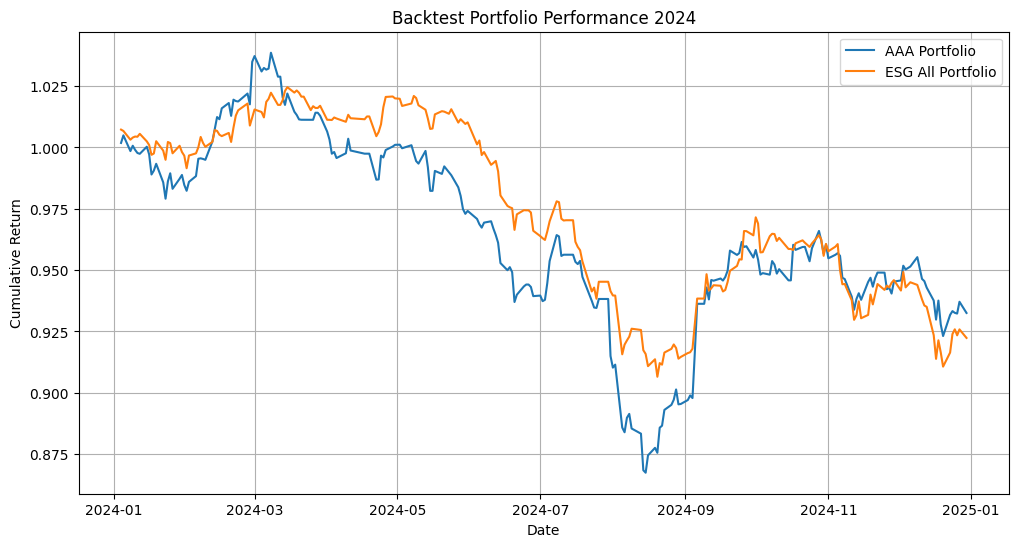

In [ ]:
# คำนวณ Cumulative Return
cumret_aaa = (1 + (price_test_aaa.pct_change().dropna() @ weights_aaa)).cumprod()
cumret_esg = (1 + (price_test_esg.pct_change().dropna() @ weights_esg)).cumprod()


# Plot Equity Curve
plt.figure(figsize=(12, 6))
plt.plot(cumret_aaa, label='AAA Portfolio')
plt.plot(cumret_esg, label='ESG All Portfolio')
plt.title('Backtest Portfolio Performance 2024')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()


## 📊 เปรียบเทียบผลลัพธ์ Backtesting ของพอร์ต AAA vs ESG ปี 2024

### 🧾 สรุปตารางเปรียบเทียบ Performance

| Metric               | AAA_Only        | ESG_All         |
|----------------------|-----------------|-----------------|
| **Total Return**     | -6.75%          | -7.77%          |
| **Annualized Return**| -7.02%          | -8.07%          |
| **Volatility**       | 9.09%           | 7.39%           |
| **Sharpe Ratio**     | -0.77           | -1.09           |
| **Max Drawdown**     | -16.49%         | -11.52%         |
| **Final Value**      | 0.93            | 0.92            |

---

### 📈 ภาพรวมจากกราฟ

- พอร์ต **AAA** (เส้นสีน้ำเงิน) มีช่วงต้นปีที่ทำผลงานดีกว่า ESG
- กลางปีเกิดภาวะตลาดปรับฐานหนัก AAA ร่วงลึกกว่า ESG
- ESG_All ผันผวนน้อยกว่าในภาพรวม แต่จบปีได้ผลตอบแทนสุทธิต่ำกว่าเล็กน้อย

---

### 📌 วิเคราะห์เชิงกลยุทธ์

| พอร์ต       | จุดแข็ง                                     | จุดอ่อน                                          |
|-------------|---------------------------------------------|---------------------------------------------------|
| **AAA_Only** | - ขาดทุนน้อยกว่า<br>- Sharpe Ratio ดีกว่า | - Volatility สูงกว่า<br>- Drawdown ลึกกว่า        |
| **ESG_All**  | - ความผันผวนต่ำกว่า<br>- Drawdown เบากว่า | - Sharpe Ratio แย่กว่า<br>- Return น้อยกว่า       |

---

🔁 **สรุป**:  
พอร์ต AAA_Only ให้ผลตอบแทนสุทธิและ Sharpe Ratio ดีกว่า แต่ก็ผันผวนและเสี่ยงกว่าพอร์ต ESG_All



# XGboost

## 1. ตรวจสอบและเตรียม DataFrame ให้พร้อมใช้

In [ ]:
# ยืนยันชื่อคอลัมน์ (ticker) ที่เราจะนำไปใช้
print("=== หุ้น AAA ที่ใช้ ===")
print(price_train_aaa.columns.tolist())
print("\n=== หุ้น ESG_ALL ที่ใช้ ===")
print(price_train_esg.columns.tolist())

# ยืนยันว่าคอลัมน์ใน train/test ทั้งคู่ตรงกัน
assert list(price_train_aaa.columns) == list(price_test_aaa.columns), "AAA train/test columns mismatch!"
assert list(price_train_esg.columns) == list(price_test_esg.columns), "ESG train/test columns mismatch!"

print("\n✅ Dataset พร้อมใช้งานแล้ว")


=== หุ้น AAA ที่ใช้ ===
['ACE.BK', 'BEM.BK', 'PTTGC.BK', 'GPSC.BK', 'BANPU.BK', 'BCPG.BK', 'TPIPP.BK', 'MTC.BK', 'M-CHAI.BK', 'CPF.BK', 'CENTEL.BK', 'SCGP.BK', 'KTC.BK', 'SJWD.BK', 'STA.BK', 'PTT.BK', 'WHAUP.BK', 'NOBLE.BK', 'THCOM.BK', 'TPBI.BK', 'BGRIM.BK', 'SIRI.BK', 'MC.BK', 'MFEC.BK', 'AJ.BK', 'AMATA.BK', 'ORI.BK', 'PB.BK', 'KBANK.BK', 'SCC.BK', 'BBL.BK', 'BPP.BK', 'TISCO.BK', 'BGC.BK', 'KTB.BK', 'CKP.BK', 'WHA.BK', 'SABINA.BK', 'CPALL.BK', 'TOP.BK', 'CPN.BK', 'TTB.BK', 'BAY.BK', 'PR9.BK', 'RATCH.BK', 'IVL.BK', 'STGT.BK', 'TMT.BK', 'TVO.BK', 'TFMAMA.BK']

=== หุ้น ESG_ALL ที่ใช้ ===
['SYNEX.BK', 'AKP.BK', 'GCAP.BK', 'TSC.BK', 'WICE.BK', 'SCG.BK', 'VIH.BK', 'EGCO.BK', 'BCPG.BK', 'COM7.BK', 'MBK.BK', 'SMPC.BK', 'BJC.BK', 'NVD.BK', 'SYMC.BK', 'TKS.BK', 'IRC.BK', 'CM.BK', 'KCE.BK', 'LH.BK', 'WHAUP.BK', 'THCOM.BK', 'UAC.BK', 'SNC.BK', 'TPBI.BK', 'BGRIM.BK', 'PLANB.BK', 'SAPPE.BK', 'SIRI.BK', 'THREL.BK', 'MFEC.BK', 'PB.BK', 'PSH.BK', 'UPF.BK', 'AH.BK', 'SAT.BK', 'MINT.BK', 'VGI.BK', 'SS

In [ ]:
# รวม DataFrame รายวัน ของทั้งสองช่วงเข้าเป็นชุดเดียวกัน
price_all_aaa = pd.concat([price_train_aaa, price_test_aaa])
price_all_esg = pd.concat([price_train_esg, price_test_esg])

# สร้าง DataFrame ราคาสิ้นเดือน (Monthly) จากข้อมูลรายวัน
#      .resample('M').last() จะดึงราคา ณ วันทำการสุดท้ายของแต่ละเดือน
price_monthly_aaa = price_all_aaa.resample('M').last()
price_monthly_esg = price_all_esg.resample('M').last()

# ตรวจสอบว่าช่วง index ครอบคลุมตั้งแต่ 2021-01-31 ... 2024-12-31
print("price_monthly_aaa:", price_monthly_aaa.shape, price_monthly_aaa.index.min(), price_monthly_aaa.index.max())
print("price_monthly_esg:", price_monthly_esg.shape, price_monthly_esg.index.min(), price_monthly_esg.index.max())


price_monthly_aaa: (48, 50) 2021-01-31 00:00:00 2024-12-31 00:00:00
price_monthly_esg: (48, 197) 2021-01-31 00:00:00 2024-12-31 00:00:00


<ipython-input-24-18f0d684639a>:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  price_monthly_aaa = price_all_aaa.resample('M').last()
<ipython-input-24-18f0d684639a>:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  price_monthly_esg = price_all_esg.resample('M').last()


## 2. สร้างตาราง Monthly Return และ Features/Target (In-Sample)

In [ ]:
# คำนวณ Monthly Return จากราคาเดือน (pct_change)
ret_monthly_aaa = price_monthly_aaa.pct_change().dropna()
ret_monthly_esg = price_monthly_esg.pct_change().dropna()

# เนื่องจากเราต้องใช้ข้อมูลถึงสิ้นเดือนธันวาคม 2023 เพื่อสร้าง features ทำนายเดือนมกราคม 2024
#       ให้เตรียมเฉพาะดัชนีเดือนต้นทาง (สิ้นเดือน 2021-2023) สำหรับสร้าง X/Y In-Sample (ปี 2021-2023)
ret_monthly_train_aaa = ret_monthly_aaa.loc[:'2023-12-31']
ret_monthly_train_esg = ret_monthly_esg.loc[:'2023-12-31']

print("ret_monthly_train_aaa range:", ret_monthly_train_aaa.index.min(), ret_monthly_train_aaa.index.max())
print("ret_monthly_train_esg range:", ret_monthly_train_esg.index.min(), ret_monthly_train_esg.index.max())


ret_monthly_train_aaa range: 2021-02-28 00:00:00 2023-12-31 00:00:00
ret_monthly_train_esg range: 2021-02-28 00:00:00 2023-12-31 00:00:00


## 3. สร้างฟังก์ชันดึงฟีเจอร์แบบ Long Format

In [ ]:
import pandas as pd
import numpy as np

def build_long_dataset_xgb(price_monthly):
    """
    สร้าง DataFrame ของฟีเจอร์ (mom3, mom6, vol3) และ target (return เดือนถัดไป)
    ในรูปแบบ Long Format (แต่ละแถว = (เดือน, หุ้น))
    - price_monthly: DataFrame index = สิ้นเดือน (2021-01-31 ถึง 2024-12-31), columns = tickers
    คืน:
      - df_long_feats: DataFrame columns=['year_month','ticker','mom3','mom6','vol3']
      - ser_long_tgt:  Series index same as df_long_feats.index, ค่า = return เดือนถัดไป
    """
    # 1) คำนวณ mom3, mom6, vol3 จากราคา สิ้นเดือน
    mom3_all = price_monthly.pct_change(periods=3)   # momentum 3 เดือน
    mom6_all = price_monthly.pct_change(periods=6)   # momentum 6 เดือน
    ret_month_all = price_monthly.pct_change()       # return เดือนปัจจุบัน
    vol3_all = ret_month_all.rolling(window=3).std() # volatility 3 เดือน

    # 2) target = return เดือนถัดไป   (shift -1)
    tgt_all = ret_month_all.shift(-1)

    # 3) กำหนดช่วง In-Sample Index = สิ้นเดือน 2021-01-31 ถึง 2023-11-30
    #    เพราะเดือน 2023-11-30 มี target = return เดือน 2023-12-31 (ข้อมูลครบ)
    idx_train = price_monthly.loc[:'2023-11-30'].index

    rows = []
    targets = []

    for m in idx_train:
        for tk in price_monthly.columns:
            f_mom3 = mom3_all.at[m, tk]
            f_mom6 = mom6_all.at[m, tk]
            f_vol3 = vol3_all.at[m, tk]
            tg_val = tgt_all.at[m, tk]

            # ข้ามถ้า feature หรือ target เป็น NaN จุดใดจุดหนึ่ง
            if pd.isna(f_mom3) or pd.isna(f_mom6) or pd.isna(f_vol3) or pd.isna(tg_val):
                continue

            rows.append({
                'year_month': m,
                'ticker':      tk,
                'mom3':       f_mom3,
                'mom6':       f_mom6,
                'vol3':       f_vol3
            })
            targets.append(tg_val)

    df_long_feats = pd.DataFrame(rows)
    ser_long_tgt  = pd.Series(targets, name='target')

    return df_long_feats, ser_long_tgt


# สร้าง Long Dataset สำหรับ AAA In-Sample
df_train_aaa_feats, ser_train_aaa_tgt = build_long_dataset_xgb(price_monthly_aaa)
print("AAA In-Sample Long Feats shape:", df_train_aaa_feats.shape)
print("AAA In-Sample Long Target shape:", ser_train_aaa_tgt.shape)

# สร้าง Long Dataset สำหรับ ESG_ALL In-Sample
df_train_esg_feats, ser_train_esg_tgt = build_long_dataset_xgb(price_monthly_esg)
print("ESG In-Sample Long Feats shape:", df_train_esg_feats.shape)
print("ESG In-Sample Long Target shape:", ser_train_esg_tgt.shape)


AAA In-Sample Long Feats shape: (1450, 5)
AAA In-Sample Long Target shape: (1450,)
ESG In-Sample Long Feats shape: (5713, 5)
ESG In-Sample Long Target shape: (5713,)


## 4.แบ่ง Train/Validation และเทรน XGBoost

In [ ]:
from sklearn.model_selection import train_test_split
import xgboost as xgb

# แยก features/target สำหรับ AAA
X_aaa_all  = df_train_aaa_feats[['mom3','mom6','vol3']]
y_aaa_all  = ser_train_aaa_tgt

X_tr_aaa, X_val_aaa, y_tr_aaa, y_val_aaa = train_test_split(
    X_aaa_all, y_aaa_all, test_size=0.2, random_state=2024
)

# แยก features/target สำหรับ ESG_ALL
X_esg_all = df_train_esg_feats[['mom3','mom6','vol3']]
y_esg_all = ser_train_esg_tgt

X_tr_esg, X_val_esg, y_tr_esg, y_val_esg = train_test_split(
    X_esg_all, y_esg_all, test_size=0.2, random_state=2024
)

# สร้าง DMatrix และเทรน XGBoost
dtrain_aaa = xgb.DMatrix(X_tr_aaa, label=y_tr_aaa)
dvalid_aaa = xgb.DMatrix(X_val_aaa,   label=y_val_aaa)

dtrain_esg = xgb.DMatrix(X_tr_esg, label=y_tr_esg)
dvalid_esg = xgb.DMatrix(X_val_esg, label=y_val_esg)

params_aaa = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'eta': 0.1,
    'max_depth': 4,
    'seed': 2024
}
params_esg = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'eta': 0.1,
    'max_depth': 4,
    'seed': 2024
}

model_aaa = xgb.train(
    params=params_aaa,
    dtrain=dtrain_aaa,
    num_boost_round=200,
    evals=[(dtrain_aaa,'train'),(dvalid_aaa,'valid')],
    early_stopping_rounds=10,
    verbose_eval=False
)

model_esg = xgb.train(
    params=params_esg,
    dtrain=dtrain_esg,
    num_boost_round=200,
    evals=[(dtrain_esg,'train'),(dvalid_esg,'valid')],
    early_stopping_rounds=10,
    verbose_eval=False
)

print("จบการเทรน XGBoost สำหรับ AAA และ ESG_ALL เรียบร้อยแล้ว")


จบการเทรน XGBoost สำหรับ AAA และ ESG_ALL เรียบร้อยแล้ว


## 5.ทำ Backtesting ปี 2024 (Out-of-Sample)

In [ ]:
import xgboost as xgb

def backtest_monthly_xgb_xgb(price_monthly, model_xgb):
    """
    - price_monthly: DataFrame ราคาสิ้นเดือน ตั้งแต่ 2021-01-31 ถึง 2024-12-31
    - model_xgb: XGBoost model ที่ train แล้ว
    คืน:
      - ser_month_ret: Series Return ของพอร์ตแต่ละเดือน (index=สิ้นเดือน 2024)
      - ser_cum_ret:   Series Cumulative Return (index=สิ้นเดือน 2024)
    """
    port_rets = []
    port_cumrets = []
    dt_list = []

    all_months = price_monthly.index
    # หา index ของ '2023-12-31'
    idx_start = all_months.get_loc(pd.to_datetime('2023-12-31'))

    for i in range(idx_start, idx_start + 12):
        date_feat = all_months[i]      # สิ้นเดือน 2023-12-31 → ทำนาย ม.ค. 2024
        date_ret  = all_months[i + 1]  # สิ้นเดือน 2024-01-31 → actual return ม.ค. 2024

        # สร้าง DataFrame ฟีเจอร์สำหรับเดือนนั้น
        feat_rows = []
        for tk in price_monthly.columns:
            f_mom3 = price_monthly[tk].pct_change(periods=3).loc[date_feat]
            f_mom6 = price_monthly[tk].pct_change(periods=6).loc[date_feat]
            f_vol3 = price_monthly[tk].pct_change().rolling(window=3).std().loc[date_feat]
            # ถ้ามี NaN ตัวใดตัวหนึ่ง (เพราะบาง ticker อาจเพิ่งเข้า) ข้ามคู่นั้นไป
            if pd.isna(f_mom3) or pd.isna(f_mom6) or pd.isna(f_vol3):
                continue
            feat_rows.append({'ticker': tk, 'mom3': f_mom3, 'mom6': f_mom6, 'vol3': f_vol3})

        if not feat_rows:
            # ถ้าไม่เหลือหุ้นใดเลย ให้ถือเงินสด → return 0
            port_rets.append(0.0)
            last_val = port_cumrets[-1] if port_cumrets else 1.0
            port_cumrets.append(last_val)
            dt_list.append(date_ret)
            continue

        df_feat_month = pd.DataFrame(feat_rows)
        dmat = xgb.DMatrix(df_feat_month[['mom3','mom6','vol3']])
        preds = model_xgb.predict(dmat)
        df_feat_month['pred'] = preds

        # เลือกเฉพาะ pred>0
        df_long = df_feat_month[df_feat_month['pred'] > 0]
        if df_long.empty:
            port_rets.append(0.0)
            last_val = port_cumrets[-1] if port_cumrets else 1.0
            port_cumrets.append(last_val)
            dt_list.append(date_ret)
            continue

        df_long['weight'] = df_long['pred'] / df_long['pred'].sum()

        # actual return เดือนนั้น
        # คำนวณ ret_monthly = price_monthly.pct_change() ตั้งแต่ 2021-01-31
        ret_m = price_monthly.pct_change().loc[date_ret]

        # คำนวณ return พอร์ต
        port_ret = sum(df_long.loc[df_long['ticker']==tk, 'weight'].iat[0] * ret_m[tk]
                       for tk in df_long['ticker'])

        port_rets.append(port_ret)
        cum_val = port_cumrets[-1] * (1 + port_ret) if port_cumrets else (1 + port_ret)
        port_cumrets.append(cum_val)
        dt_list.append(date_ret)

    ser_month_ret = pd.Series(port_rets, index=dt_list)
    ser_cum_ret   = pd.Series(port_cumrets, index=dt_list)
    return ser_month_ret, ser_cum_ret


# Backtest AAA_XGB
ser_mret_aaa, ser_cumret_aaa = backtest_monthly_xgb_xgb(price_monthly_aaa, model_aaa)

# Backtest ESGALL_XGB
ser_mret_esg, ser_cumret_esg = backtest_monthly_xgb_xgb(price_monthly_esg, model_esg)

print("AAA_XGB monthly ret:", ser_mret_aaa)
print("AAA_XGB cumulative:",  ser_cumret_aaa)
print("ESG_XGB monthly ret:", ser_mret_esg)
print("ESG_XGB cumulative:",  ser_cumret_esg)


<ipython-input-34-a9a1fd4c730c>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_long['weight'] = df_long['pred'] / df_long['pred'].sum()
<ipython-input-34-a9a1fd4c730c>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_long['weight'] = df_long['pred'] / df_long['pred'].sum()
<ipython-input-34-a9a1fd4c730c>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https

AAA_XGB monthly ret: 2024-01-31   -0.033091
2024-02-29    0.055432
2024-03-31   -0.063541
2024-04-30   -0.026473
2024-05-31   -0.060686
2024-06-30   -0.067252
2024-07-31   -0.050020
2024-08-31   -0.052742
2024-09-30    0.114299
2024-10-31   -0.117509
2024-11-30   -0.035424
2024-12-31   -0.070316
dtype: float64
AAA_XGB cumulative: 2024-01-31    0.966909
2024-02-29    1.020506
2024-03-31    0.955662
2024-04-30    0.930363
2024-05-31    0.873904
2024-06-30    0.815132
2024-07-31    0.774358
2024-08-31    0.733517
2024-09-30    0.817357
2024-10-31    0.721310
2024-11-30    0.695758
2024-12-31    0.646836
dtype: float64
ESG_XGB monthly ret: 2024-01-31    0.118914
2024-02-29    0.023116
2024-03-31    0.003207
2024-04-30   -0.025910
2024-05-31    0.047813
2024-06-30   -0.078092
2024-07-31   -0.086165
2024-08-31    0.045660
2024-09-30    0.114120
2024-10-31   -0.098769
2024-11-30   -0.032541
2024-12-31   -0.116526
dtype: float64
ESG_XGB cumulative: 2024-01-31    1.118914
2024-02-29    1.144778

<ipython-input-34-a9a1fd4c730c>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_long['weight'] = df_long['pred'] / df_long['pred'].sum()


## 6.คำนวณ Metrics และสรุปผล

In [ ]:
def calc_metrics_monthly_xgb(month_ret):
    final_v = (1 + month_ret).cumprod().iloc[-1]
    total_r = final_v - 1
    n = len(month_ret)  # ปกติคือ 12 เดือน
    ann_r = (1 + total_r) ** (12 / n) - 1
    vol_r = month_ret.std() * np.sqrt(12)
    sharpe = ann_r / vol_r if vol_r != 0 else np.nan

    cumprod = (1 + month_ret).cumprod()
    rolling_max = cumprod.cummax()
    drawdown = cumprod / rolling_max - 1
    max_dd = drawdown.min()

    return {
        "Total Return": total_r,
        "Annualized Return": ann_r,
        "Volatility": vol_r,
        "Sharpe Ratio": sharpe,
        "Max Drawdown": max_dd,
        "Final Value": final_v
    }

metrics_aaa_xgb = calc_metrics_monthly_xgb(ser_mret_aaa)
metrics_esg_xgb = calc_metrics_monthly_xgb(ser_mret_esg)

metrics_df_xgb = pd.DataFrame([metrics_aaa_xgb, metrics_esg_xgb], index=['AAA_XGB','ESGALL_XGB'])

styled_df = metrics_df_xgb.style.format({
    "Total Return": "{:.2%}",
    "Annualized Return": "{:.2%}",
    "Volatility": "{:.2%}",
    "Sharpe Ratio": "{:.2f}",
    "Max Drawdown": "{:.2%}",
    "Final Value": "{:.2f}"
}).background_gradient(cmap='YlGn', subset=["Sharpe Ratio", "Annualized Return"]) \
  .background_gradient(cmap='OrRd_r', subset=["Volatility", "Max Drawdown"]) \
  .set_caption("📊 เปรียบเทียบผลลัพธ์ Backtesting ของพอร์ต AAA_XGB vs ESGALL_XGB")

styled_df




,Total Return,Annualized Return,Volatility,Sharpe Ratio,Max Drawdown,Final Value
AAA_XGB,-35.32%,-35.32%,21.31%,-1.66,-36.62%,0.65
ESGALL_XGB,-11.38%,-11.38%,27.65%,-0.41,-24.40%,0.89


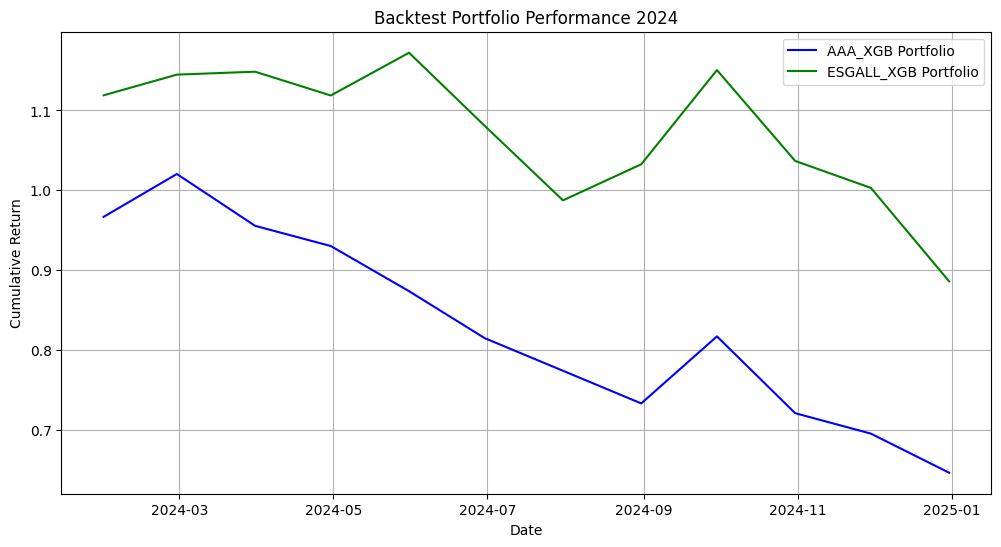

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(ser_cumret_aaa.index, ser_cumret_aaa.values, label='AAA_XGB Portfolio', color='blue')
plt.plot(ser_cumret_esg.index, ser_cumret_esg.values, label='ESGALL_XGB Portfolio', color='green')

plt.title('Backtest Portfolio Performance 2024')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()


## 📊 เปรียบเทียบผลลัพธ์ Backtesting ของพอร์ต AAA vs ESG ปี 2024

### 🧾 สรุปตารางเปรียบเทียบ Performance

| Metric                | AAA\_XGB | ESGALL\_XGB |
| --------------------- | -------- | ----------- |
| **Total Return**      | -35.32%  | -11.38%     |
| **Annualized Return** | -35.32%  | -11.38%     |
| **Volatility**        | 21.31%   | 27.65%      |
| **Sharpe Ratio**      | -1.66    | -0.41       |
| **Max Drawdown**      | -36.62%  | -24.40%     |
| **Final Value**       | 0.65     | 0.89        |

---

### 📈 ภาพรวมจากกราฟ

* พอร์ต **AAA\_XGB** (เส้นสีน้ำเงิน) เริ่มต้นปีได้ดี แต่กลับ **ร่วงต่อเนื่อง** ชัดเจนหลังไตรมาสแรก และ **จบปีด้วยผลตอบแทนต่ำสุด**
* พอร์ต **ESGALL\_XGB** (เส้นสีเขียว) แม้จะมีความผันผวน แต่ยัง **รักษาระดับและ outperform AAA ได้ชัดเจน** ในช่วงครึ่งปีหลัง
* ในภาพรวม ESG ดู **เสถียรและทนแรงสั่นสะเทือนของตลาดได้ดีกว่า**

---

### 📌 วิเคราะห์เชิงกลยุทธ์

| พอร์ต           | จุดแข็ง                                                                                   | จุดอ่อน                                                            |
| --------------- | ----------------------------------------------------------------------------------------- | ------------------------------------------------------------------ |
| **AAA\_XGB**    | - Sharpe Ratio ต่ำสุด แสดงว่าให้ reward ต่อความเสี่ยงไม่คุ้ม<br>- ช่วงต้นปีเคยมีจังหวะบวก | - Drawdown ลึกมาก (-36%)<br>- ผลตอบแทนรวมติดลบหนักสุด              |
| **ESGALL\_XGB** | - ผลตอบแทนดีกว่า AAA ชัดเจน<br>- Max Drawdown เบากว่า                                     | - Volatility สูงกว่า (ผันผวน)<br>- ยังไม่สามารถสร้างผลตอบแทนบวกได้ |

---

🔁 **สรุป**:
พอร์ต **ESGALL\_XGB** แม้จะไม่สามารถสร้างผลตอบแทนบวกได้ แต่ก็ **ให้ความเสถียรและควบคุมความเสี่ยงได้ดีกว่า** AAA\_XGB มาก ทั้งในแง่ของ Drawdown และ Sharpe Ratio ที่ลดลงน้อยกว่า
ส่วน **AAA\_XGB** แสดงอาการ overfitting หรือเลือกหุ้นผิดจังหวะชัดเจนในปี 2024 — ต้องปรับปรุงโมเดลและกลยุทธ์การเลือกหุ้นใหม่อย่างมีนัยสำคัญ.

หากคุณต้องการเปรียบเทียบกับกลยุทธ์อื่น เช่น Modern Portfolio Theory (MPT) ที่เคยทำไว้ก่อนหน้านี้ ก็สามารถใช้ cumulative return ชุดเดียวกันมาเทียบได้ทันที.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# รวม metrics ของทั้ง 4 แบบ
all_metrics_df = pd.DataFrame([
    metrics_aaa,       # MPT: AAA only
    metrics_esg,       # MPT: ESG All
    metrics_aaa_xgb,   # XGBoost: AAA
    metrics_esg_xgb    # XGBoost: ESG
], index=['AAA_MPT', 'ESG_All_MPT', 'AAA_XGB', 'ESG_All_XGB'])

# กำหนดรูปแบบตาราง
styled_all_df = all_metrics_df.style.format({
    "Total Return": "{:.2%}",
    "Annualized Return": "{:.2%}",
    "Volatility": "{:.2%}",
    "Sharpe Ratio": "{:.2f}",
    "Max Drawdown": "{:.2%}",
    "Final Value": "{:.2f}"
}).background_gradient(cmap='YlGn', subset=["Sharpe Ratio", "Annualized Return"]) \
  .background_gradient(cmap='OrRd_r', subset=["Volatility", "Max Drawdown"]) \
  .set_caption("📊 เปรียบเทียบผลลัพธ์ Backtesting ของพอร์ตทุกกลยุทธ์ (MPT + XGBoost)")

display(styled_all_df)


# เตรียมข้อมูลสำหรับกราฟ
# สำหรับ MPT portfolio
cumret_aaa = (1 + (price_test_aaa.pct_change().dropna() @ weights_aaa)).cumprod()
cumret_esg = (1 + (price_test_esg.pct_change().dropna() @ weights_esg)).cumprod()

# === รวมเป็น DataFrame เดียวเพื่อความง่ายในการ plot === #
# ให้แน่ใจว่า Series ของ XGBoost มีค่าและ index ตรงกับ linear portfolios
ser_cumret_aaa = ser_cumret_aaa.reindex(cumret_aaa.index, method='ffill')
ser_cumret_esg = ser_cumret_esg.reindex(cumret_esg.index, method='ffill')

# จากนั้นค่อยรวมใหม่
cumrets_df = pd.DataFrame({
    'AAA_Linear': cumret_aaa,
    'ESG_All_Linear': cumret_esg,
    'AAA_XGB': ser_cumret_aaa,
    'ESG_All_XGB': ser_cumret_esg
})


,Total Return,Annualized Return,Volatility,Sharpe Ratio,Max Drawdown,Final Value
AAA_MPT,-6.75%,-7.02%,9.09%,-0.77,-16.49%,0.93
ESG_All_MPT,-7.77%,-8.07%,7.39%,-1.09,-11.52%,0.92
AAA_XGB,-35.32%,-35.32%,21.31%,-1.66,-36.62%,0.65
ESG_All_XGB,-11.38%,-11.38%,27.65%,-0.41,-24.40%,0.89


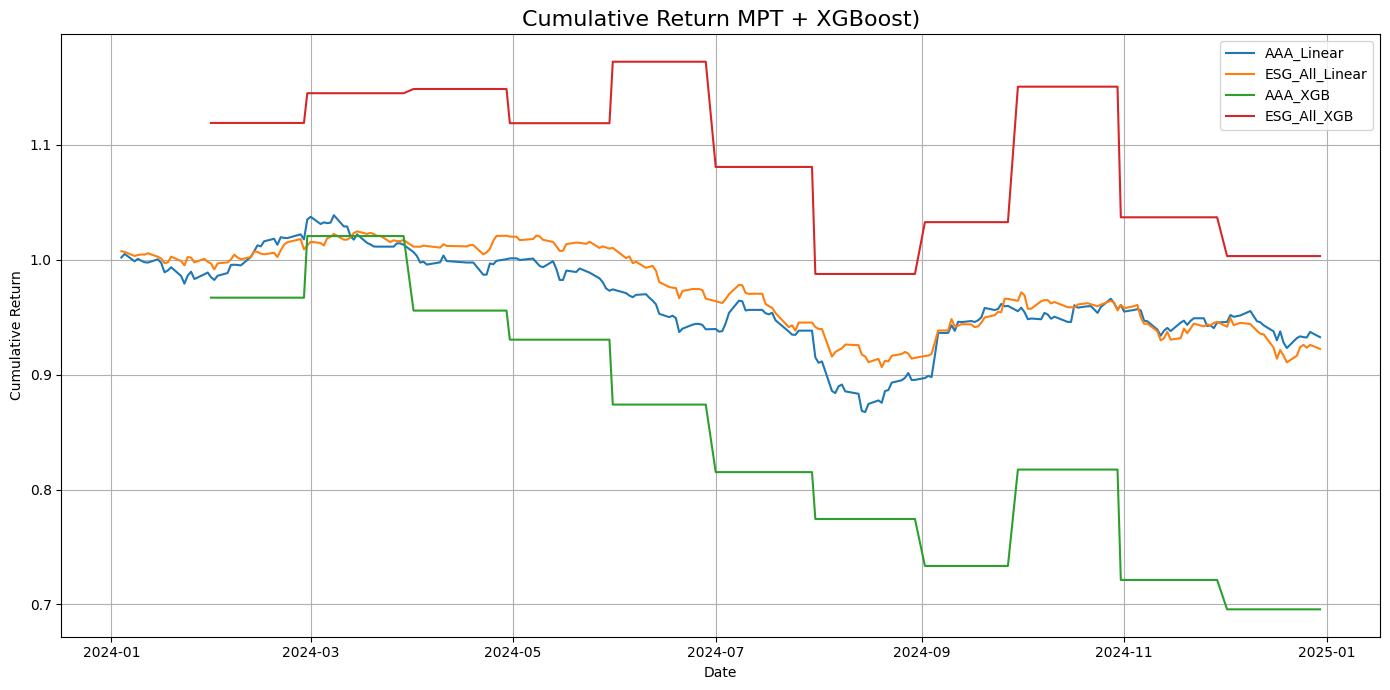

In [ ]:
# วาดกราฟ
plt.figure(figsize=(14, 7))
for col in cumrets_df.columns:
    plt.plot(cumrets_df.index, cumrets_df[col], label=col)

plt.title('Cumulative Return MPT + XGBoost)', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

ทำไมเมื่อรวมเป็นกราฟเดียวกัน เส้นกราฟจึงดูแปลก

*   กราฟ ser_cumret_aaa และ ser_cumret_esg ที่วาดแยกในตอนแรก แสดงผลตอบแทนสะสม ณ สิ้นแต่ละเดือน (มี 12 จุด)
*   กราฟ AAA_XGB และ ESG_All_XGB ในกราฟรวม แสดงผลตอบแทนสะสมที่ถูก Reindex ให้มี Index เป็นรายวัน โดยใช้ค้างค่าจากสิ้นเดือนล่าสุด ทำให้กราฟดูเป็นขั้นบันได




---

# 📊 สรุปผลตาราง Performance Metrics

| กลยุทธ์           | Total Return | Annualized Return | Volatility | Sharpe Ratio | Max Drawdown | Final Value |
| ----------------- | ------------ | ----------------- | ---------- | ------------ | ------------ | ----------- |
| **AAA\_MPT**      | -6.75%       | -7.02%            | 9.09%      | -0.77        | -16.49%      | 0.93        |
| **ESG\_All\_MPT** | -7.77%       | -8.07%            | 7.39%      | -1.09        | -11.52%      | 0.92        |
| **AAA\_XGB**      | -35.32%      | -35.32%           | 21.31%     | -1.66        | -36.62%      | 0.65        |
| **ESG\_All\_XGB** | -11.38%      | -11.38%           | 27.65%     | -0.41        | -24.40%      | 0.89        |

---

## 📈 วิเคราะห์ผลจาก Cumulative Return

จากกราฟ **Cumulative Return (2024)**:

* **กลยุทธ์ AAA\_XGB** แสดงให้เห็นว่าแม้จะเริ่มต้นได้ไม่แย่ แต่ผลตอบแทนลดลงแรงกว่ากลยุทธ์อื่นตลอดปี ทำให้มี Max Drawdown สูงที่สุดที่ -36.62% และ Final Value เหลือเพียง 0.65 เท่าของเงินต้น
* **ESG\_All\_XGB** มีความผันผวนสูงที่สุด (Volatility 27.65%) แต่ให้ผลตอบแทนที่ดีกว่า AAA\_XGB มาก ทั้งในแง่ Total Return และ Drawdown
* **กลยุทธ์ MPT** ทั้ง AAA และ ESG\_All ให้ผลตอบแทนที่ "ขาดทุนน้อย" กว่า XGB อย่างชัดเจน แม้ยังเป็นลบ โดย ESG\_All\_MPT เสียหายน้อยสุดด้าน Drawdown

---

## 🔍 วิเคราะห์เชิงเปรียบเทียบ

### ✅ กลุ่ม ESG vs AAA

* ทั้งใน XGB และ MPT, กลุ่ม **ESG\_All** มี Sharpe Ratio และ Drawdown ที่ดีกว่า AAA สม่ำเสมอ
* แสดงให้เห็นว่า **การลงทุนในกลุ่ม ESG** อาจมีความเสถียรกว่าและจัดการความเสี่ยงได้ดีกว่า แม้กำไรไม่เด่น

### ✅ MPT vs XGBoost

* **MPT ให้ผลลัพธ์ที่ขาดทุนน้อยกว่าและเสถียรกว่า XGBoost**
* **XGBoost มีความผันผวนสูงกว่าและ Drawdown หนักกว่า** ซึ่งอาจเกิดจาก Overfitting หรือความไม่เหมาะสมกับชุดข้อมูลนี้

---






#สาเหตุเชิงเทคนิค: ทำไม XGBoost จึงเสียเปรียบ

1. **Overfitting กับข้อมูลเทรนนิ่ง**
   XGBoost ถูกออกแบบมาให้เก่งในการจับ “ความสัมพันธ์เชิงสถิติแบบซับซ้อน” ระหว่างตัวแปรอินพุต (เช่น สัญญาณราคา, ปัจจัยการเงิน, ปัจจัย ESG ฯลฯ) กับผลตอบแทนในอดีต แต่กลยุทธ์พอร์ตโฟลิโอไม่ได้ขึ้นกับการคาดการณ์ “หุ้นตัวใดตัวหนึ่งจะขึ้นหรือจะลง” เพียงอย่างเดียว หากแต่ต้องดู “ความสัมพันธ์เชิง covariance” เพื่อกระจายความเสี่ยงและปรับน้ำหนักอย่างเหมาะสม

   * เมื่อ XGBoost ถูกฝึก (train) ให้โฟกัสหาจุดเด่นสุดๆ บนข้อมูลในอดีต มันจึงอาจจับสัญญาณที่เป็น “noise” หรือ “สัญญาณลวง” (spurious signal) มากเกินไป พอถึงเวลาทดสอบจริง (out-of-sample) พอร์ตที่จัดตาม XGBoost จึงล้มเหลวในการรับมือกรณีตลาดพลิกอย่างรุนแรง (tail risk)

2. **ไม่มีการ “optimize พอร์ต” อย่างเป็นระบบเหมือน MPT**

   * **MPT** จะคำนวณทั้ง “อัตราผลตอบแทนที่คาดหวัง” (Expected Return) และ “เมทริกซ์ covariance” ระหว่างสินทรัพย์ แล้วเลือกจุดบน “Efficient Frontier” ที่ให้ Sharpe Ratio สูงสุด (หรือเราสามารถตั้งเงื่อนไขอื่นๆ เช่น วัตถุประสงค์ minimization of variance ได้)
   * **XGBoost** โดยทั่วไปจะพยายามทำนาย “ผลตอบแทนแบบจุด” (point estimate) ของแต่ละหุ้น/กองทุน จากนั้นเรามักจะเอาผลลัพธ์จากโมเดลมาสร้างพอร์ตแบบ heuristic (เช่น จัดสัดส่วนตามลำดับผลตอบแทนที่โมเดลให้คะแนน) ซึ่งไม่เคยการันตีว่าจะอยู่บนพรมแดน Efficient Frontier วิธีนี้จึงเสี่ยงต่อการ “กระจุกตัว” (concentration risk) ในสินทรัพย์ไม่กี่ตัวที่โมเดลเชียร์ว่า “จะดีสุด” แต่พอมันพลาดขึ้นมา ผลเสียก็จะรุนแรงกว่าการกระจายแบบ MPT

3. **ความผันผวนในระยะสั้น (Short-Term Whipsaw)**
   XGBoost มักจะสร้าง “สัญญาณซื้อ–ขาย” บ่อยครั้ง ถ้ามีการอัพเดตข้อมูลใหม่ (เช่น สัญญาณเทคนิคใหม่ หรือ ข่าวเชิง ESG ที่เปลี่ยนตลอดเวลา) โมเดลอาจพลิกคำทำนายกะทันหัน ส่งผลให้พอร์ตซื้อขายถี่ (turnover สูง) และเจอทุนเปิด–ปิด (bid-ask spread) รวมถึงค่าธรรมเนียมที่อาจกินผลตอบแทนไปด้วย

   * ในขณะที่ MPT มักจะทำ Rebalance ค่อนข้างน้อย (เช่น ปรับเดือนละครั้ง ไตรมาสละครั้ง หรือครึ่งปีครั้ง) ทำให้ต้นทุนธุรกรรมต่ำกว่าและลดการ Whipsaw ออกไป


